In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 298 (delta 74), reused 67 (delta 58), pack-reused 171
Receiving objects: 100% (298/298), 53.98 MiB | 30.83 MiB/s, done.
Resolving deltas: 100% (135/135), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.optim import Adam
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from tqdm.auto import tqdm, trange
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from dul_2021.utils.hw8_utils import *

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


<Figure size 432x288 with 0 Axes>

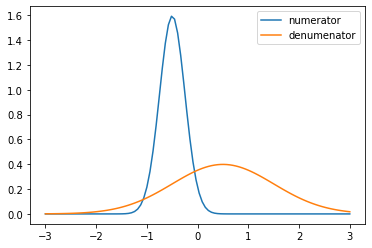

In [ ]:
plot_data_q1() # distributions

In [ ]:
class KMM(nn.Module): 
  def __init__(self, hd=128, sigma=0.15):
    super().__init__()
    self.sigma = sigma
    self.r = nn.Sequential(nn.Linear(1, hd), nn.ReLU(), 
                           nn.Linear(hd, hd), nn.ReLU(),
                           nn.Linear(hd, 1), nn.Softplus())
    
  def fit(self, data_nu, data_de, bs=512, lr=1e-3, n_epochs=500):
    data_nu_load = data.DataLoader(data_nu, batch_size=bs, shuffle=True)
    data_de_load = data.DataLoader(data_de, batch_size=bs, shuffle=True)
    optimizer = Adam(self.r.parameters(), lr=lr)

    for epoch in tqdm(range(n_epochs)):
      for (b_nu, b_de) in zip(data_nu_load, data_de_load): 
        b_nu = b_nu.view(- 1, 1).float()
        n_nu = len(b_nu)
        r_nu = torch.ones_like(b_nu)

        b_de = b_de.view(- 1, 1).float()
        n_de = len(b_de)
        r_de = self.r(b_de)
        
        kdn = - (- 2 * (b_de @ b_nu.T) + b_de**2 + b_nu.T**2) / (2 * self.sigma**2)
        kdn = torch.exp(kdn)
        kdd = - (- 2 * (b_de @ b_de.T) + b_de**2 + b_de.T**2) / (2 * self.sigma**2)
        kdd = torch.exp(kdd)

        loss = ((r_de.T @ kdd @ r_de) / ((n_de)**2)) -  (2 * (r_de.T @ kdn @ r_nu) / (n_de * n_nu))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

In [ ]:
def q1(data_nu, data_de):
  """
  data_nu - An [n_nu] dataset with samples from numerator's distribution
  data_de - An [n_de] dataset with samples from denominators's distribution
  
  Returns
    - a np.array with density ratios of np.linspace(-2., 2, num=100)
  """
  model = KMM()
  model.fit(data_nu, data_de)
  with torch.no_grad():
  ### you need to calculate density ratio on x and return it
    x = np.linspace(-2., 2, num=100)        
    p = model.r(torch.FloatTensor(x.reshape(- 1, 1))).cpu().numpy()
  return p

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

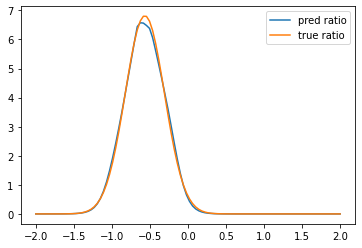

In [ ]:
q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [4]:
class Classifier(nn.Module):
  def __init__(self, ld, hd):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(),
                              nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(), 
                              nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(),
                              nn.Conv2d(128, 128, 3, 2, 1), nn.ReLU()
                              )
    
    self.lin = nn.Sequential(nn.Linear(4 * 4 * 128 + ld, hd), nn.ReLU(), 
                             nn.Linear(hd, hd), nn.ReLU(), 
                             nn.Linear(hd, 1)
                             )
    
  def forward(self, x, z):
    out = self.conv(x).flatten(1)
    return self.lin(torch.cat((out, z), dim=1))

In [5]:
class Encoder(nn.Module):
  def __init__(self, ld, nd):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(),
                              nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(), 
                              nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(), 
                              nn.Conv2d(128, 128, 3, 2, 1), nn.ReLU()
                              )
    
    self.lin = nn.Linear(4 * 4 * 128 + nd, ld)

  def forward(self, x, noise):
    out = self.conv(x).flatten(1)
    return self.lin(torch.cat((out, noise), dim=1))

In [6]:
class Decoder(nn.Module):
  def __init__(self, ld):
    super().__init__()
    self.conv = nn.Sequential(nn.ConvTranspose2d(128, 128, 3, 2, 1), nn.ReLU(), 
                              nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(), 
                              nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(), 
                              nn.Conv2d(32, 1, 3, 1, 1)
                              )
    
    self.lin = nn.Sequential(nn.Linear(ld, 4 * 4 * 128), nn.ReLU())

  def forward(self, x):
    bs = x.shape[0]
    return self.conv(self.lin(x).reshape(bs, 128, 4, 4))

In [44]:
class AVB(nn.Module):
  def __init__(self, ld=16, nd=2, hd=64):
    super().__init__()
    self.T = Classifier(ld, hd)
    self.E = Encoder(ld, nd)
    self.D = Decoder(ld)
    self.l_dist = MultivariateNormal(torch.zeros(ld, device=device), 
                                     torch.eye(ld, device=device))
    self.n_dist = MultivariateNormal(torch.zeros(nd, device=device), 
                                     torch.eye(nd, device=device))    
    
  def loss(self, b):
    bs = b.shape[0]
    noise = self.n_dist.sample((bs,))
    z = self.E(b, noise)
    b_recon = self.D(z)
    loss_recon = F.mse_loss(b, b_recon, reduction='none').\
                  reshape(bs, - 1).sum(dim=1)
    loss_elbo = loss_recon + self.T(b, z)
    with torch.no_grad():
      noise = self.n_dist.sample((bs,))
      z = self.E(b, noise)
    sam = self.l_dist.sample((bs,))
    real = torch.sigmoid(self.T(b, z))
    fake = torch.sigmoid(self.T(b, sam))
    loss_real = F.binary_cross_entropy(real, torch.ones_like(real))
    loss_fake = F.binary_cross_entropy(fake, torch.zeros_like(fake))
    loss_clf = loss_real + loss_fake
    return loss_elbo.mean(), loss_clf.mean()

  @torch.no_grad()
  def test(self, test_data):
    n = 0
    loss_elbo_summed = 0
    loss_clf_summed = 0
    for b in test_data:
      bs = b.shape[0]
      loss_elbo, loss_clf = self.loss(b.to(device))
      n += bs
      loss_elbo_summed += bs * loss_elbo
      loss_clf_summed += bs * loss_clf
    loss_elbo_mean = loss_elbo_summed.item() / n
    loss_clf_mean = loss_clf_summed.item() / n
    return [loss_elbo_mean, loss_clf_mean]

  def fit(self, train_data, test_data, epochs, lr=1e-5):
    l_train, l_test = [], []
    optim1 = Adam(list(self.E.parameters()) + \
                  list(self.D.parameters()), lr=lr)
    optim2 = Adam(self.T.parameters(), lr=lr)
    l_test.append(self.test(test_data))
    for epoch in trange(epochs):
      for b in train_data:
        loss_elbo, loss_clf = self.loss(b.to(device))
        optim1.zero_grad()
        loss_elbo.backward()
        optim1.step()
        optim2.zero_grad()
        loss_clf.backward()
        optim2.step()
        l_train.append([loss_elbo.item(), loss_clf.item()])
    l_test.append(self.test(test_data))
    return np.array(l_train), np.array(l_test)

  def sample(self, n):
    return torch.sigmoid(self.D(self.l_dist.sample((n,))))

In [45]:
def q2(train_data, test_data):
  """
  train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
   Returns
  - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
  - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
  - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
  """
  train_data = np.transpose(train_data, (0, 3, 1, 2)).astype(np.float32)
  training = data.DataLoader(train_data, batch_size=256, shuffle=True)

  test_data = np.transpose(test_data, (0, 3, 1, 2)).astype(np.float32)
  testing = data.DataLoader(test_data, batch_size=256, shuffle=True)
    
  model = AVB().to(device)
  l_train, l_test = model.fit(training, testing, epochs=15)

  samples = model.sample(100)
  samples = samples.detach().cpu().numpy()

  return l_train[:, 0], l_train[:, 1], l_test[:, 0], l_test[:, 1], samples

  0%|          | 0/15 [00:00<?, ?it/s]

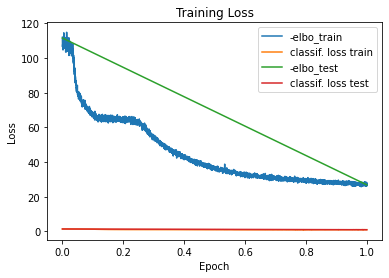

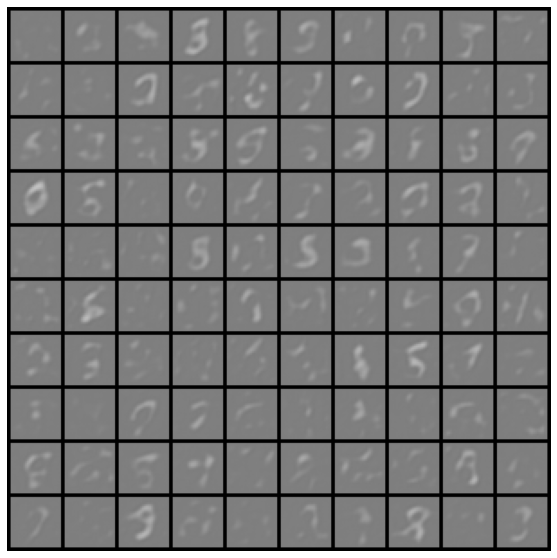

In [46]:
q2_results(q2)